In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
# from matplotlib.ticker import FormatStrFormatter
from matplotlib.ticker import NullFormatter
from matplotlib.ticker import FuncFormatter
# from matplotlib.colors import LogNorm
import numpy as np
import math as ma

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from scipy.io import readsav
from scipy.interpolate import interp1d
# from scipy.interpolate import interp2d

import extinction
import igm

import loadSP as lsp
import cosmo
import halos
# import logInterp 

plt.rcParams['figure.figsize'] = (13,11)
plt.rcParams['font.size'] = 32
import gc

In [2]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')

def div_formatter(x,pos):
    return format(x/1000, '.1f')

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)
divfmt  = FuncFormatter(div_formatter)
logfmt  = FuncFormatter(log_formatter)
nullfmt = NullFormatter()

In [3]:
# Cosmology from my paper
myCosmo = FlatLambdaCDM(H0=71.0, Om0=0.267, Ob0=0.0449, name='myCosmo')
Odm = 0.267 - 0.0449
print(Odm)
# Make sure we have halo information for this z... hop/...
z = 8.0
num = 121 # This is the output_00num file that has the "info_" for finding the boxsize... see map above.

print("Using astropy cosmology: physical size {:.2f}".format((3 * u.Mpc/(1.0+z) * 1/0.71).to(u.kpc)))

sizeKeys = np.loadtxt('zKeysForSPfiles.txt',skiprows=1)
print("Physical Boxsize from kKey file = {}".format(sizeKeys[sizeKeys[::,0] == z][0,1] * u.kpc))
boxsizekpc = sizeKeys[sizeKeys[::,0] == z][0,1]
gc.collect()
print('rho_critdm 0={:.3e}'.format(myCosmo.critical_density0* Odm) )
print('rho_crit 2={:.3e}'.format(myCosmo.critical_density(2) ))
print('rho_critdm 2={:.3e}'.format(myCosmo.critical_density(2) * myCosmo.Odm(2)))
print('rho_critdm 2={:.3e}'.format(myCosmo.critical_density0 * (1.0+2)**3 * myCosmo.Odm(2)))


0.22210000000000002
Using astropy cosmology: physical size 469.48 kpc
Physical Boxsize from kKey file = 468.62 kpc
rho_critdm 0=2.103e-30 g / cm3
rho_crit 2=7.527e-29 g / cm3
rho_critdm 2=5.678e-29 g / cm3
rho_critdm 2=1.929e-28 g / cm3


In [5]:
locsRaw, mass, bt, Z, PZ, PPF = lsp.loadSP(z)
##############################################
# Need to correct the Z and PZ for the pristine
# fraction of the SP... 
##############################################
fpolLim = 1e-5
##############################################
# Need to correct the Z and PZ for the pristine
# fraction of the SP... 
##############################################
fpol = 1.0-PPF
fpol[fpol < fpolLim] = 0.0 # Don't form polluted stars when fpol is very small
##############################################
# Convert to mass fraction ... 
##############################################
Z  = Z * 0.02
PZ = PZ * 0.02    
##############################################
# Correct Z for polluted fraction. Use max
# correction: Z_corr = <Z>/(1-PPF). Those at
# -inf are placed below z_crit -> Pop III stars
##############################################
Z_corr = Z/fpol
Z_corr[np.isinf(Z_corr)]     = 1e-10 # Make the Z of these particles map to the Pop III flux dict indx
Z_corr[Z_corr < 1e-5 * 0.02] = 1e-10 # Same ... 
##################################################
# Map ZP of sps < Z_crit to 0.0 
##################################################
ZP_corr = PZ/fpol
ZP_corr[np.isinf(ZP_corr)]     = 0.0 # Map to zero primordial fraction
ZP_corr[ZP_corr < 1e-5 * 0.02] = 0.0


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:23: RuntimeWarning: divide by zero encountered in true_divide
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:29: RuntimeWarning: divide by zero encountered in true_divide


In [6]:
bt

array([  5.65290728e+08,   5.66935845e+08,   5.67070131e+08, ...,
         6.52749550e+08,   6.52906744e+08,   6.53019167e+08])

In [7]:
# Compute age of the star particles...

baseAge = cosmo.ageAtz(71,z) # ageAtZ return Myr, parameters are H and z
spAges = baseAge - bt/1e6    # bt from SP file is in yr, convert to Myr... # *********** #
print("min sp age {:.2f} Myr".format(min(spAges)))
print("max sp age {:.2f} Myr".format(max(spAges)))
print("min sp Z {:.2e} Solar".format(min(Z)))
print("max sp Z {:.2e} Solar".format(max(Z)))

min sp age 1.77 Myr
max sp age 459.01 Myr
min sp Z 1.00e-10 Solar
max sp Z 6.18e-03 Solar


In [8]:
##
## Load the halo locations
## hop halo pos file key:    #   npart,mass,cont.frac,xc,yc,zc,uc,vc,wc
##
halosRawPos = lsp.loadHaloGrps(num,
                    prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hop/') # Returns positions normalized to (-0.5, 0.5)
halossizes  = lsp.loadHaloSizes(num,
                    prefix='/Users/earnric/Research/RAMSES-Data/27Aug15-3Mpc/hop/') # Returns DM particle counts for each halo

#halosPos = halosRawPos * boxsizekpc
halosPos = halosRawPos * 3000.0 # Comoving box (per h)
locs = (locsRaw/boxsizekpc) * 3000.0 # Comoving coords of SPs 
print("Num of halos @ {} = {}".format(z,len(halosRawPos)))

Num of halos @ 8.0 = 3871


In [9]:
arcPerKpc = myCosmo.arcsec_per_kpc_comoving(z=z)
print('Comoving @ {}, {:.4f}:'.format(z,arcPerKpc))
arcPerKpc = myCosmo.arcsec_per_kpc_proper(z=z)
print('Proper @ {}, {:.4f}:'.format(z,arcPerKpc))
print('Proper @ {}, {:.4f}:'.format(z,1/arcPerKpc))

kpcPerArcSec = cosmo.arcAtz(71,z=z,om=0.267) # size of an arcsec at the specified reshift in kpc
print('My Comoving @ {}, {:.4f}:'.format(z,arcPerKpc/(1+z)))
print('My Proper @ {}, {:.4f}:'.format(z,arcPerKpc))
print('My Proper @ {}, {:.4f}:'.format(z,1/arcPerKpc))

Comoving @ 8.0, 0.0225 arcsec / kpc:
Proper @ 8.0, 0.2022 arcsec / kpc:
Proper @ 8.0, 4.9448 kpc / arcsec:
My Comoving @ 8.0, 0.0225 arcsec / kpc:
My Proper @ 8.0, 0.2022 arcsec / kpc:
My Proper @ 8.0, 4.9448 kpc / arcsec:


In [10]:
minhalos=500
gc.collect()

12

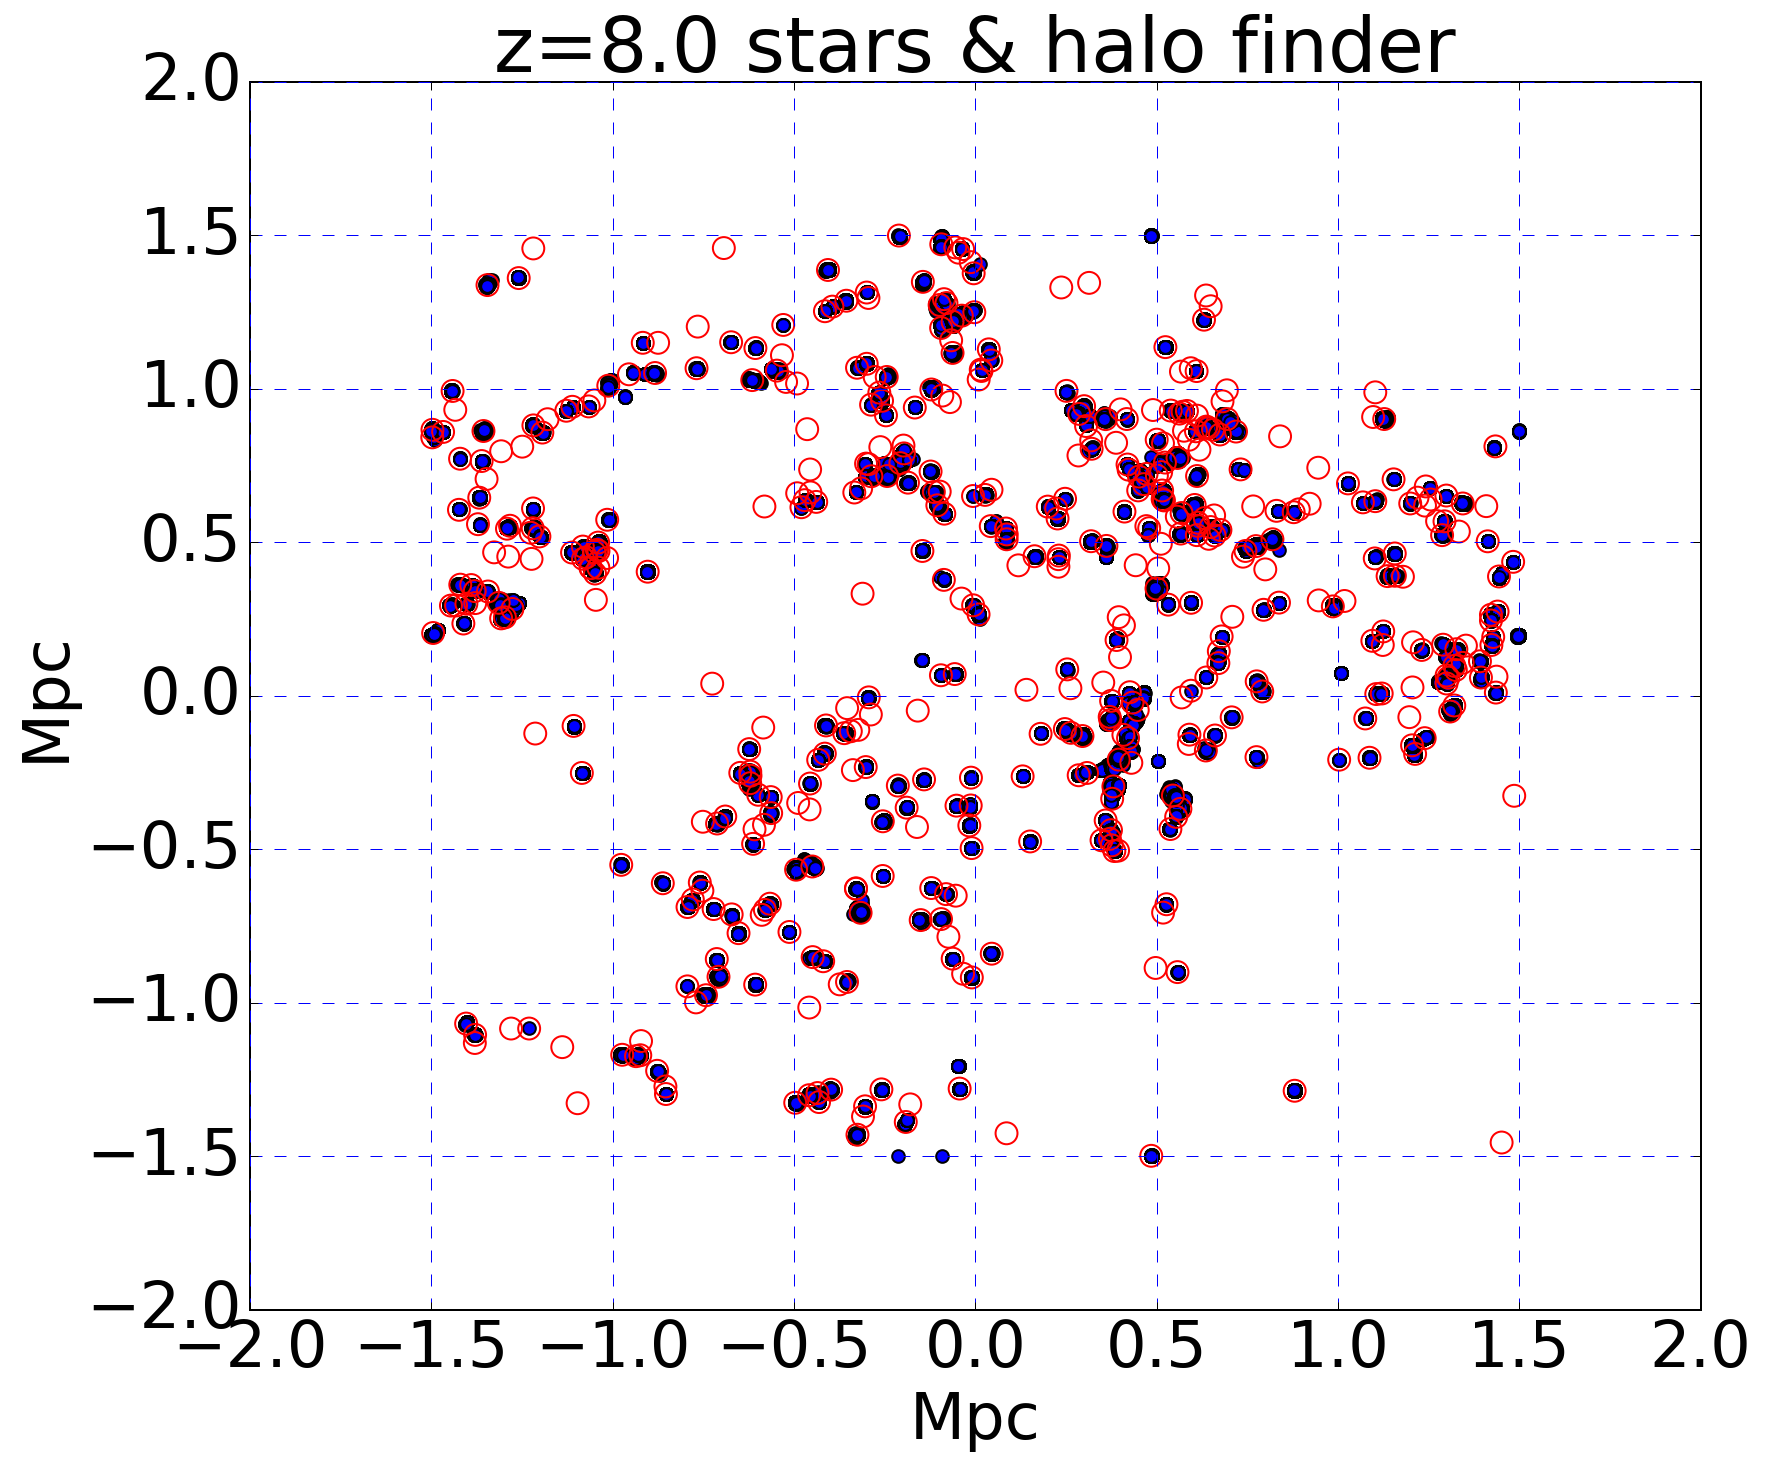

4482

In [11]:
htp = min([minhalos,len(halosRawPos)])
labels = ['halo{0}'.format(i) for i in range(len(halosPos))]
plt.scatter(locs[:,0]/1000,locs[:,1]/1000,s=40,c='b') # Plot star particles
plt.scatter(halosPos[:htp,0]/1000,halosPos[:htp,1]/1000,s=120,facecolors='none', edgecolors='r') # Plot halo locs
plt.grid(b=True, which='major', color='b', linestyle='--')
plt.xlabel('Mpc')
plt.ylabel('Mpc')
# plt.xlim([-2,2])
# plt.ylim([-2,2])
plt.title('z=%.1lf stars & halo finder'%z)
# for label, x, y in zip(labels, halosPos[:htp,0]/1000,halosPos[:htp,1]/1000):
#     plt.annotate(
#         label, 
#         xy = (x, y), xytext = (-20, 20),
#         textcoords = 'offset points', ha = 'right', va = 'bottom',fontsize=10,
#         bbox = dict(boxstyle = 'round,pad=0.05', fc = 'yellow', alpha = 0.5),
#         arrowprops = dict(arrowstyle = '->', connectionstyle = 'arc3,rad=0'))
plt.show()
gc.collect()

# Load Seth's data and compare

In [48]:
#
# Load Seth's data for z = 6
# PADOVA data 1994
#
sethPath = '/Users/earnric/Research/Research-Observability/Software-Models/sethData'
sethFile160z8 = sethPath + '/F160W_WFC3_bc_8.00' # IDL Save file
sethFile225z8 = sethPath + '/F225W_WFC3_bc_8.00' # IDL Save file
sethFile435z8 = sethPath + '/F435W_ACS_bc_8.00'  # IDL Save file
sethFile098z8 = sethPath + '/F098M_WFC3_bc_8.00' # IDL Save file
sethFile850z8 = sethPath + '/F850LP_ACS_bc_8.00' # IDL Save file
sethFile775z8 = sethPath + '/F775W_ACS_bc_8.00' # IDL Save file
sethFile606z8 = sethPath + '/F606W_ACS_bc_8.00' # IDL Save file
seth160z8Data = readsav(sethFile160z8)
seth225z8Data = readsav(sethFile225z8)
seth435z8Data = readsav(sethFile435z8)
seth098z8Data = readsav(sethFile098z8)
seth850z8Data = readsav(sethFile850z8)
seth775z8Data = readsav(sethFile775z8)
seth606z8Data = readsav(sethFile606z8)
seth160z8Data.keys()
sethsData = ['seth160z8Data' ,'seth225z8Data', 'seth435z8Data', 'seth098z8Data', 'seth850z8Data', 'seth775z8Data']

In [31]:
myHaloFluxesz8 = np.genfromtxt('haloFluxes_z_8.0_.txt',names=True,delimiter=',') # RELOAD - after generating flux
print(myHaloFluxesz8.dtype.names)

('indx', 'ZZ_sun', 'Z_PZ_sun', 'MM_sun', 'F098M_WFC3', 'F105W_WFC3', 'F125W_WFC3', 'F160W_WFC3', 'F225W_WFC3', 'F275W_WFC3', 'F336W_WFC3', 'F435W_ACS', 'F606W_ACS', 'F775W_ACS', 'F850LP_ACS', 'H', 'J', 'Ks', 'f070w', 'f090w', 'f115w', 'f140m', 'f150w', 'f162m', 'f182m', 'f200w', 'f210m', 'f250m', 'f277w', 'f300m', 'f335m', 'f356w', 'f360m', 'f410m', 'f430m', 'f444w', 'f460m', 'f480m', 'F098M_WFC3_P3', 'F105W_WFC3_P3', 'F125W_WFC3_P3', 'F160W_WFC3_P3', 'F225W_WFC3_P3', 'F275W_WFC3_P3', 'F336W_WFC3_P3', 'F435W_ACS_P3', 'F606W_ACS_P3', 'F775W_ACS_P3', 'F850LP_ACS_P3', 'H_P3', 'J_P3', 'Ks_P3', 'f070w_P3', 'f090w_P3', 'f115w_P3', 'f140m_P3', 'f150w_P3', 'f162m_P3', 'f182m_P3', 'f200w_P3', 'f210m_P3', 'f250m_P3', 'f277w_P3', 'f300m_P3', 'f335m_P3', 'f356w_P3', 'f360m_P3', 'f410m_P3', 'f430m_P3', 'f444w_P3', 'f460m_P3', 'f480m_P3')


In [32]:
myHaloFluxesz8['F775W_ACS'][0:10]

array([  5.94250000e-38,   4.75760000e-38,   1.92590000e-38,
         3.71050000e-38,   4.16130000e-39,   3.16190000e-39,
         8.72670000e-39,   4.43170000e-39,   4.10790000e-39,
         3.15370000e-39])

# Compute flux with Seths data..

In [15]:
omDM   = 0.222 # From 27Aug15 sim: # = Om0 - Ob0 = 0.267 - 0.0449
h0     = 0.71
dmMass = 5.58e4 * omDM / h0               # Dark Matter particle mass [M_sun]
rho0DM = myCosmo.critical_density0 * omDM # Remember to use (1+z) factor to scale to redshift...


# Limit the number of halos considered...
# Based on an approx guess as to the upper lim for halos
# as a func of z. This way over-est, but keeps things from
# getting crazy.
# {{16, 250}, {11, 500}, {5, 1500}}
def maxHalos(z):
    return int(10 * z**2 - 336 * z + 2900)
#
# Compute the Total Mass in DM particles ...
#
def totMass(numParts):
    return dmMass * numParts * u.Msun


In [51]:

#
# Seth's data is all for Z = 0.02!!
#
seth160z8 = interp1d(np.log10(seth160z8Data['age']),np.log10(seth160z8Data['filtfluxz'][0][0]),kind='linear')
seth225z8 = interp1d(np.log10(seth225z8Data['age']),np.log10(seth225z8Data['filtfluxz'][0][0]),kind='linear')
seth435z8 = interp1d(np.log10(seth435z8Data['age']),np.log10(seth435z8Data['filtfluxz'][0][0]),kind='linear')
seth850z8 = interp1d(np.log10(seth850z8Data['age']),np.log10(seth850z8Data['filtfluxz'][0][0]),kind='linear')
seth775z8 = interp1d(np.log10(seth775z8Data['age']),np.log10(seth775z8Data['filtfluxz'][0][0]),kind='linear')
seth098z8 = interp1d(np.log10(seth098z8Data['age']),np.log10(seth098z8Data['filtfluxz'][0][0]),kind='linear')
seth606z8 = interp1d(np.log10(seth606z8Data['age']),np.log10(seth606z8Data['filtfluxz'][0][0]),kind='linear')

z=8
overDens    = 100.0 # For virial radius computation. Typical halo overdensity as compared to background rho
denScaleFac = 0.90  # For virial radius ... fraction of the radius of the halo's overdensity radius to consider for sps
haloCritRho = myCosmo.critical_density(z) * overDens * myCosmo.Odm(z) 

fpolLim = 1e-5

gc.collect()
filename = 'seth-haloFluxes_z_{:.1f}_.txt'.format(z) 
outfile  = [] # Empty list for output ... 
numHalos = min(777,len(halosPos)) # The maxHalos func keeps us from considerings 5000+ halos.
haloNum  = 0 # Since we skip empty halos, keep track of number actually processed
processedHalos = [] # Keeps track of unique halos processed: unique halo => diff number of sps and/or total mass

overDens    = 100.0 # For virial radius computation. Typical halo overdensity as compared to background rho
denScaleFac = 0.90  # For virial radius ... fraction of the radius of the halo's overdensity radius to consider for sps
haloCritRho = myCosmo.critical_density(z) * overDens * myCosmo.Odm(z) 

haloNum = 0

# Build the output file header ... 
headerStr  = 'indx, <Z>/Z_sun, <Z_P>/Z_sun, M/M_sun, '
headerStr += 'F775, F850, F435, F225, F160, F606, F775_P3, F850_P3, F435_P3, F225_P3, F160_P3, F606_P3'
fmtStr = '%d, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e, %.4e'

###########################################################################################
# Loop over each halo -- process star particles -- determine/total flux
###########################################################################################
for indx in range(10):
    # Compute virial radius and scale ... use as radius to find star particles
    radius = ((totMass(halossizes['count'][indx]) * 3.0/(4.0 * ma.pi) * 1.0/(haloCritRho))**(1.0/3.0)).to(u.kpc) * (1.0+z)
    radius = radius.value * denScaleFac # Radius of stars to include around halo center coord
    print(" ** Halo {} virial radius {:.2f}".format(indx,radius * u.kpc))
    halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getHaloStars(locs,mass,spAges,Z_corr,ZP_corr,PPF,
                                                                          halosPos,indx,radius)
    halospages = halospages * 1e6 # Convert Myr to yr...
    fpolH = 1.0 - halospPPF
    fpolH[fpolH < fpolLim] = 0.0
    ##################################################
    # spAges in yr
    # halospZ,halospPZ in mass-fraction and corrected
    # halosplocs in comoving coordinates
    ##################################################
    N = len(halospmass)
    if (N == 0):
        print(" ****** skipping halo {}, empty".format(indx))
        continue
    totHaloMass = np.sum(halospmass)
    if [N, totHaloMass] in processedHalos: # Make sure we aren't processing same halo (with diff indx)
        print(" ****** skipping halo {}, already processed ".format(indx))
        continue
    # If we get here, process the halo stars... 
    processedHalos.append([N,totHaloMass])

    print(" ** Working on halo {} with {} star particles & mass {:.2e} M_sun.".format(indx,N,totHaloMass))
    ##################################################
    # Initialize filter totals for this halo
    # We'll keep track of total flux in filter, and PopIII
    # flux in filter ... 
    ##################################################
    haloFiltTots      = [0.0 for i in range(6)] # Init with 0.0
    haloFiltTotPopIII = [0.0 for i in range(6)]
    theFluxForStar    = [0.0 for i in range(6)]
    ##################################################
    # Loop over the star particles in the halo ...
    # Add up the flux in each filter...
    ##################################################
    for spZ,spAge,spMass in zip(halospZ,np.log10(halospages),halospmass): # spZ is mass fraction, spAge is log10(age [yr])
#headerStr += 'F775, F850, F435, F225, F160, F606, F775_P3, F850_P3, F435_P3, F225_P3, F160_P3, F606_P3'
        theFluxForStar[0] = 10**seth775z8(spAge)
        theFluxForStar[1] = 10**seth850z8(spAge)
        theFluxForStar[2] = 10**seth435z8(spAge)
        theFluxForStar[3] = 10**seth225z8(spAge)
        theFluxForStar[4] = 10**seth160z8(spAge)
        theFluxForStar[5] = 10**seth606z8(spAge)
        if spZ == 1e-10: # If we're a POPIII star, add flux to POP III star total -- in filt
            for i in range(6):
                haloFiltTotPopIII[i] += theFluxForStar[i] * spMass

        for i in range(6):
            haloFiltTots[i] += theFluxForStar[i] * spMass # Always add the flux to the total flux for the filter
        # END PROCESS STARS IN HALO

    gc.collect()            
    # Compute aveZ for the halo
    aveZ = np.sum(halospmass * halospZ)/np.sum(halospmass)
    aveZ = aveZ / 0.02 # Back to solar units... 
    print("  Halo {} ave Z (solar) {:.2e}".format(indx,aveZ))

    # Compute the mass of stars' primordial metals
    # 1 - ppf is the polluted fraction of stars, by mass
    # pzf/Z is then the fraction of primordial metals
    # (1-ppf) * pzf / Z is hence the fraction of stars polluted only by primordial metals
    avePZ = np.sum(halospmass * fpolH * halospPZ/halospZ)/np.sum(halospmass) 
    avePZ = avePZ / 0.02 # Back to solar units... 
    print("  Halo {} ave PZ (solar) {:.2e}".format(indx,avePZ))

    aLine = [haloNum] + [aveZ] + [avePZ] + [totHaloMass] + haloFiltTots + haloFiltTotPopIII

    outfile.append(aLine)
    haloNum += 1
    gc.collect()
    # END PROCESS A HALO LOOP -- All galaxies at redshift z have now been processed

print("Writing flux file... for z={}".format(z))
np.savetxt(filename, np.array(outfile), fmt=fmtStr, delimiter=', ', header=headerStr) # (values) to get row-wise write
# END PROCESS A REDSHIFT LOOP


/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in log10
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in log10
/Users/earnric/anaconda/envs/py3k/lib/python3.5/site-packages/ipykernel/__main__.py:11: RuntimeWarning: invalid value encountered in log10


 ** Halo 0 virial radius 53.39 kpc
 ** Working on halo 0 with 89509 star particles & mass 6.57e+07 M_sun.
  Halo 0 ave Z (solar) 6.71e-02
  Halo 0 ave PZ (solar) 2.04e+00
 ** Halo 1 virial radius 52.34 kpc
 ** Working on halo 1 with 46523 star particles & mass 3.42e+07 M_sun.
  Halo 1 ave Z (solar) 6.34e-02
  Halo 1 ave PZ (solar) 6.72e+00
 ** Halo 2 virial radius 51.07 kpc
 ** Working on halo 2 with 69375 star particles & mass 5.13e+07 M_sun.
  Halo 2 ave Z (solar) 7.07e-02
  Halo 2 ave PZ (solar) 3.62e+00
 ** Halo 3 virial radius 47.68 kpc
 ** Working on halo 3 with 10370 star particles & mass 7.59e+06 M_sun.
  Halo 3 ave Z (solar) 4.16e-02
  Halo 3 ave PZ (solar) 1.56e+01
 ** Halo 4 virial radius 46.47 kpc
 ** Working on halo 4 with 53056 star particles & mass 3.91e+07 M_sun.
  Halo 4 ave Z (solar) 6.47e-02
  Halo 4 ave PZ (solar) 4.69e+00
 ** Halo 5 virial radius 46.25 kpc
 ** Working on halo 5 with 31263 star particles & mass 2.30e+07 M_sun.
  Halo 5 ave Z (solar) 4.83e-02
  Halo 

In [52]:
haloFluxesz8seth= np.genfromtxt('seth-haloFluxes_z_8.0_.txt',names=True,delimiter=',')
print(haloFluxesz8seth775.dtype.names)

('indx', 'ZZ_sun', 'Z_PZ_sun', 'MM_sun', 'F775', 'F850', 'F435', 'F225', 'F160', 'F775_P3', 'F850_P3', 'F435_P3', 'F225_P3', 'F160_P3')


5073

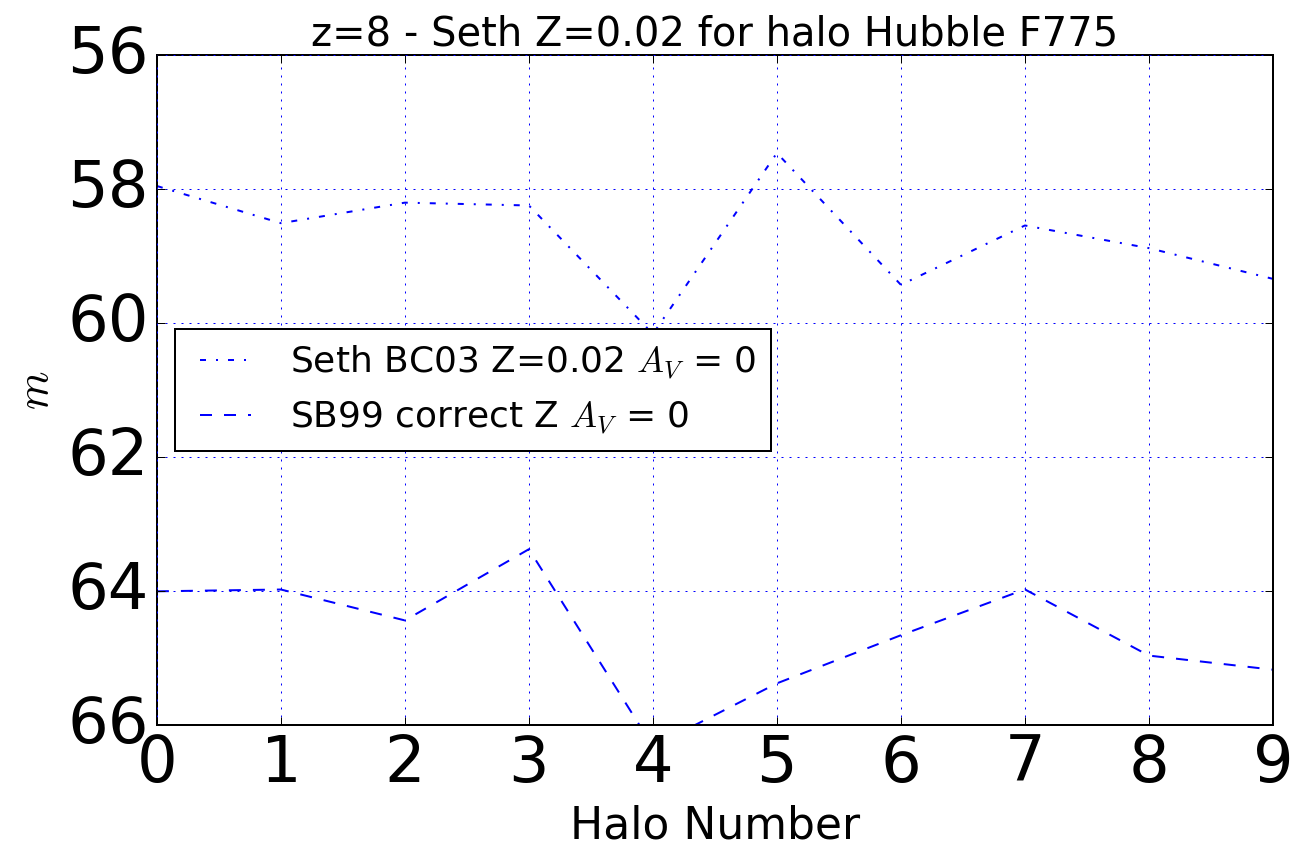

In [53]:
labelsize = 22
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(np.arange(0,10),-2.5*np.log10(haloFluxesz8seth['F775'][0:10]/haloFluxesz8seth['MM_sun'][0:10])-48.6,"b-.")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['F775W_ACS'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"b--")
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'Halo Number', size=labelsize)
ax.set_ylabel(r'$m$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle=':')
ax.set_title(r'z=8 - Seth Z=0.02 for halo Hubble F775',size=labelsize-2)
#ax.xaxis.set_major_formatter(logfmt)
# ax.yaxis.set_major_formatter(logfmt)
ax.invert_yaxis()
ax.set_ylim([66,56])
ax.legend(['Seth BC03 Z=0.02 $A_V$ = 0','SB99 correct Z $A_V$ = 0'], 
          loc='center left', fontsize=18 )
gc.collect()


311

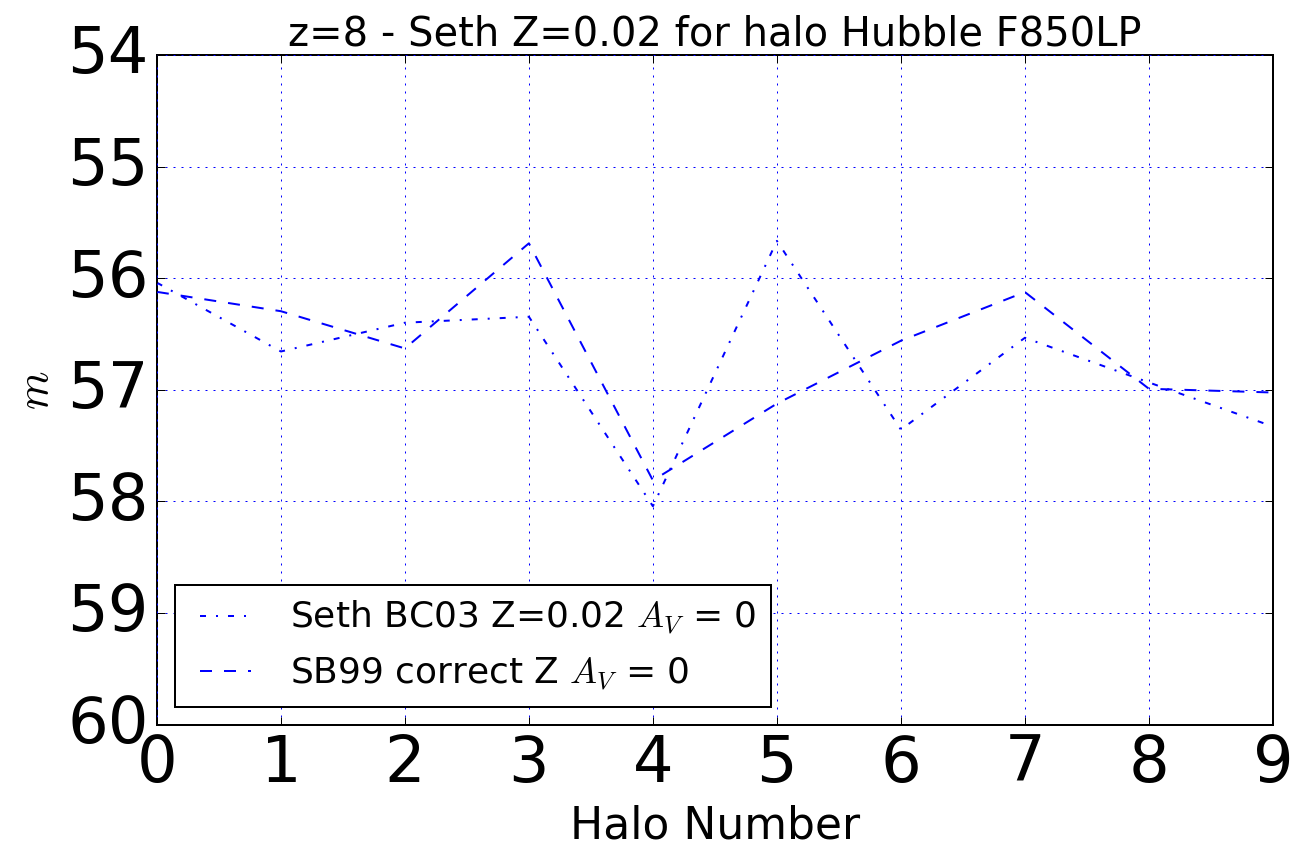

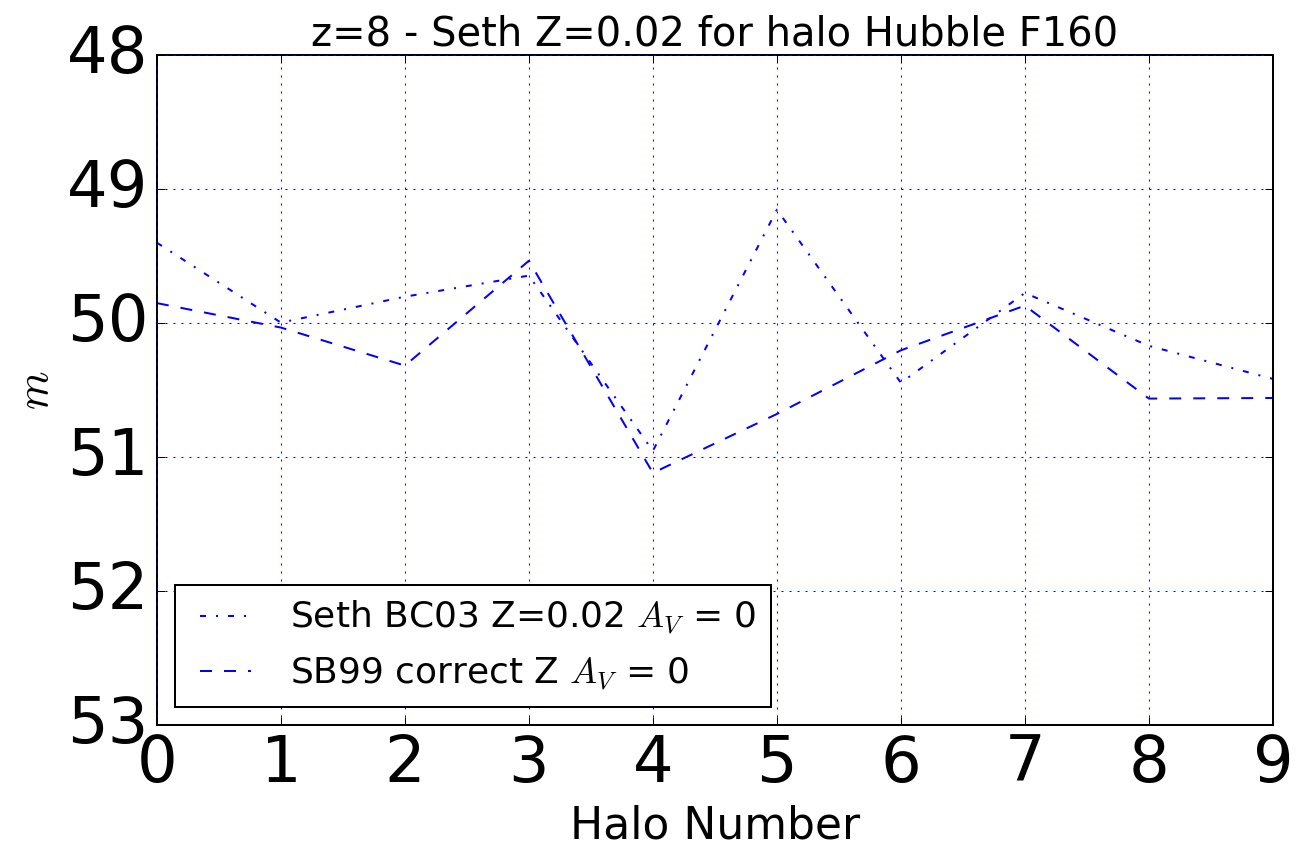

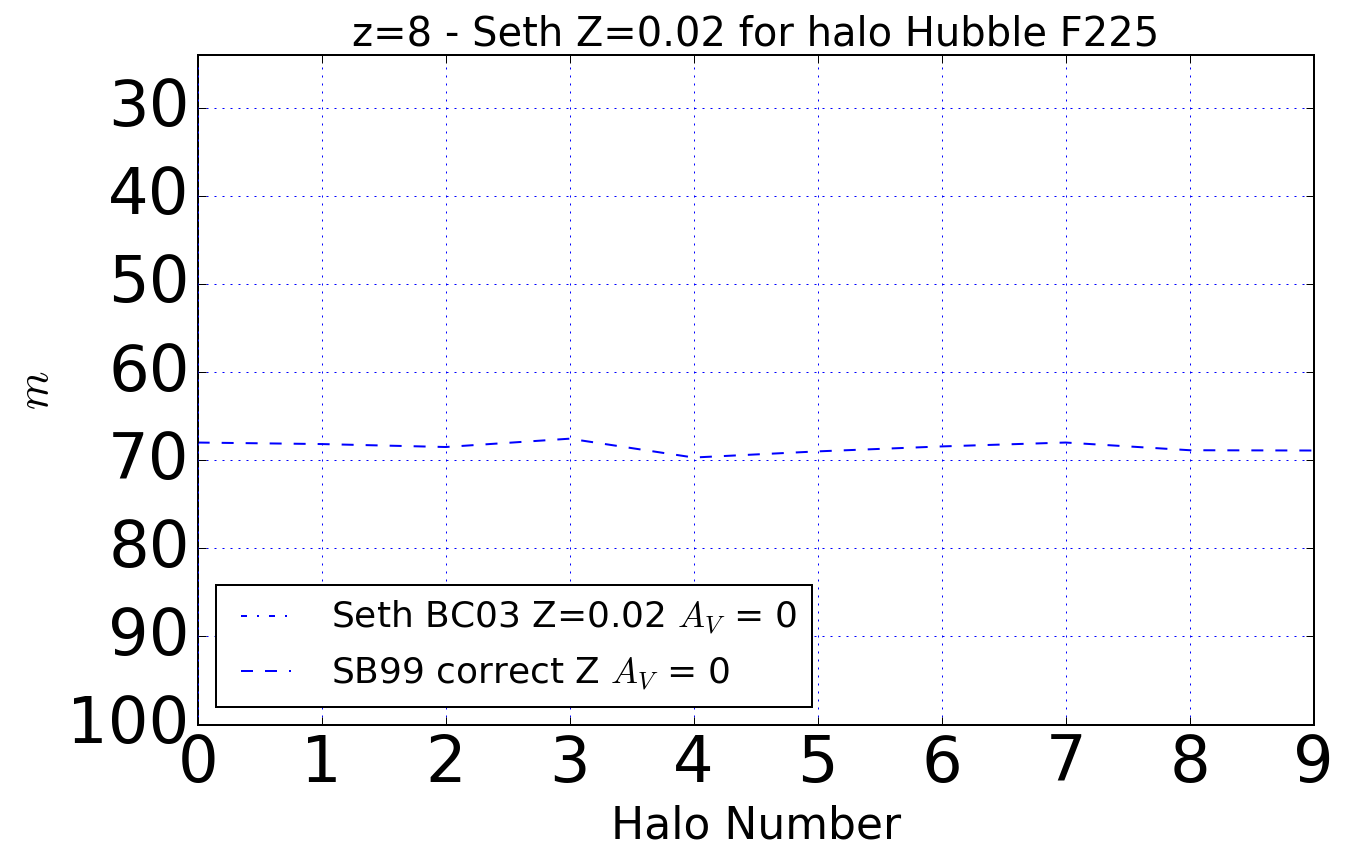

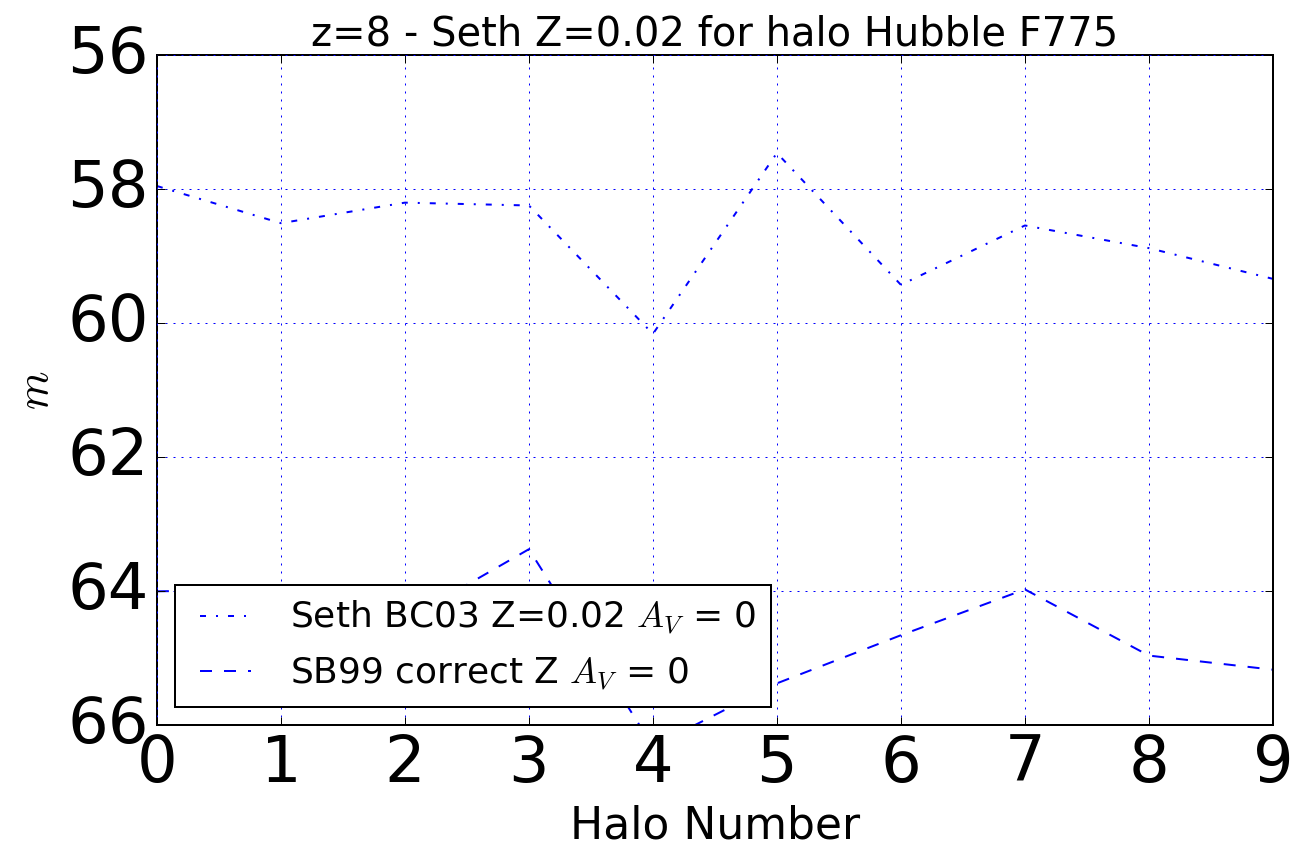

In [54]:
# Compare seths Halo computation at Z = 0.02 and his flux/M_sun across time...
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(np.arange(0,10),-2.5*np.log10(haloFluxesz8seth['F850'][0:10]/haloFluxesz8seth['MM_sun'][0:10])-48.6,"b-.")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['F850LP_ACS'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"b--")
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'Halo Number', size=labelsize)
ax.set_ylabel(r'$m$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle=':')
ax.set_title(r'z=8 - Seth Z=0.02 for halo Hubble F850LP',size=labelsize-2)
#ax.xaxis.set_major_formatter(logfmt)
# ax.yaxis.set_major_formatter(logfmt)
ax.invert_yaxis()
ax.set_ylim([60,54])
ax.legend(['Seth BC03 Z=0.02 $A_V$ = 0','SB99 correct Z $A_V$ = 0'], 
          loc='lower left', fontsize=18 )
gc.collect()


fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(np.arange(0,10),-2.5*np.log10(haloFluxesz8seth['F160'][0:10]/haloFluxesz8seth['MM_sun'][0:10])-48.6,"b-.")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['F160W_WFC3'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"b--")
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'Halo Number', size=labelsize)
ax.set_ylabel(r'$m$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle=':')
ax.set_title(r'z=8 - Seth Z=0.02 for halo Hubble F160',size=labelsize-2)
#ax.xaxis.set_major_formatter(logfmt)
# ax.yaxis.set_major_formatter(logfmt)
ax.invert_yaxis()
ax.set_ylim([53,48])
ax.legend(['Seth BC03 Z=0.02 $A_V$ = 0','SB99 correct Z $A_V$ = 0'], 
          loc='lower left', fontsize=18 )
gc.collect()

fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(np.arange(0,10),-2.5*np.log10(haloFluxesz8seth['F225'][0:10]/haloFluxesz8seth['MM_sun'][0:10])-48.6,"b-.")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['F225W_WFC3'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"b--")
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'Halo Number', size=labelsize)
ax.set_ylabel(r'$m$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle=':')
ax.set_title(r'z=8 - Seth Z=0.02 for halo Hubble F225',size=labelsize-2)
#ax.xaxis.set_major_formatter(logfmt)
# ax.yaxis.set_major_formatter(logfmt)
ax.invert_yaxis()
ax.set_ylim([100,24])
ax.legend(['Seth BC03 Z=0.02 $A_V$ = 0','SB99 correct Z $A_V$ = 0'], 
          loc='lower left', fontsize=18 )
gc.collect()
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ax.plot(np.arange(0,10),-2.5*np.log10(haloFluxesz8seth['F775'][0:10]/haloFluxesz8seth['MM_sun'][0:10])-48.6,"b-.")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['F775W_ACS'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"b--")
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'Halo Number', size=labelsize)
ax.set_ylabel(r'$m$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle=':')
ax.set_title(r'z=8 - Seth Z=0.02 for halo Hubble F775',size=labelsize-2)
#ax.xaxis.set_major_formatter(logfmt)
# ax.yaxis.set_major_formatter(logfmt)
ax.invert_yaxis()
ax.set_ylim([66,56])
ax.legend(['Seth BC03 Z=0.02 $A_V$ = 0','SB99 correct Z $A_V$ = 0'], 
          loc='lower left', fontsize=18 )
gc.collect()


In [95]:
# The F775 filter is very Blue and the BC03 data flux for young stars exists, but it does not for SB99
# See proj2-compareAndCheck-Schaerer-SB99-BC03

In [116]:
halosplocs,halospmass,halospages,halospZ,halospPZ,halospPPF = halos.getHaloStars(locs,mass,spAges,Z,PZ,PPF,
                                                                          halosPos,2,size)

(10, 1000)

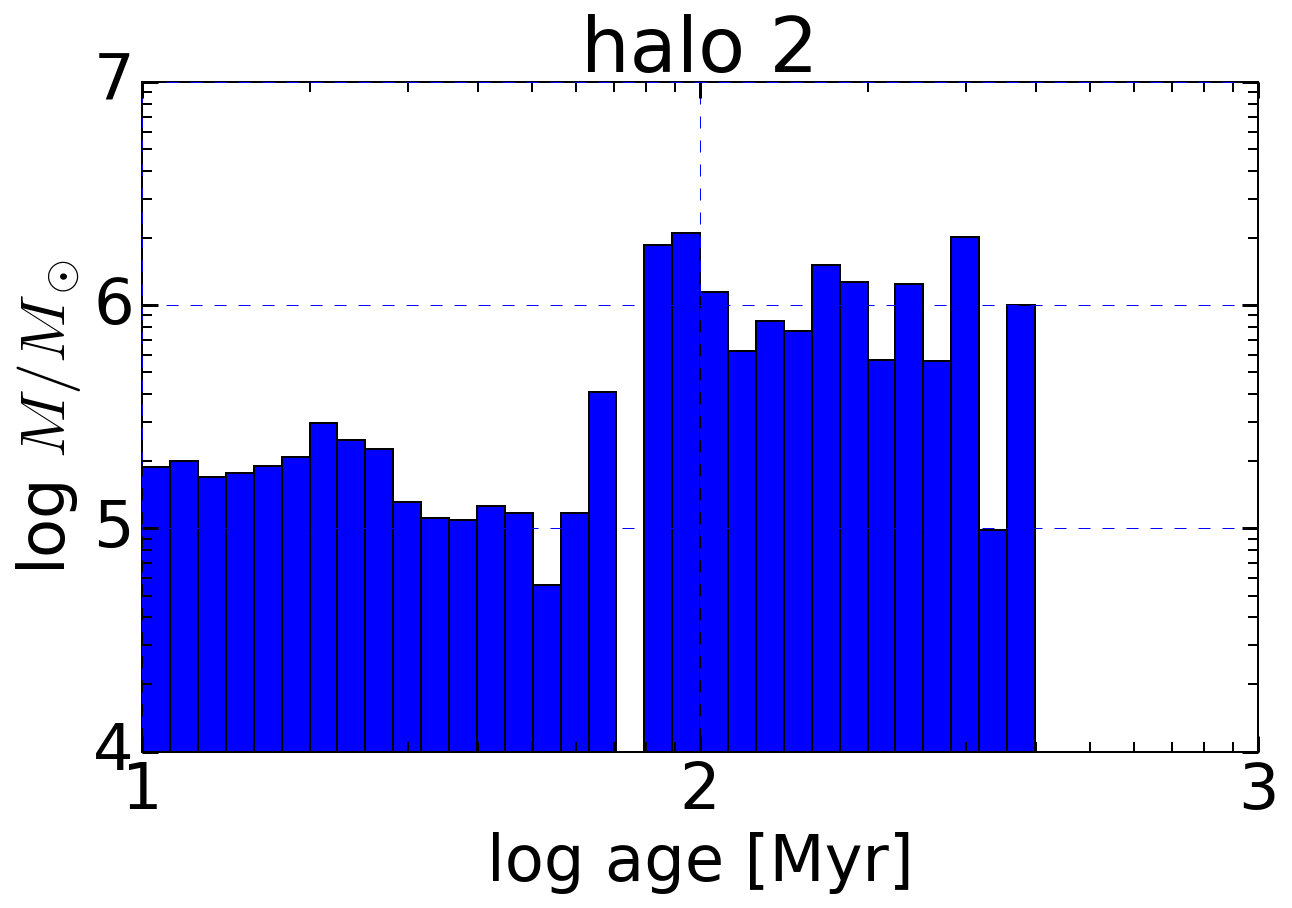

In [117]:
#
# Age of halo star particles - histogram
#
fig = plt.figure(figsize=(10,6))
ax = plt.axes()

ageBins = np.logspace(0,3,61) # TO match the SEDs we have from Schaerer, use 0.05 dex steps

n, bins, patches = ax.hist(halospages,bins=ageBins, weights=halospmass)
ax.set_xscale('log')
ax.set_yscale('log')
ax.xaxis.set_major_formatter(logfmt)
ax.yaxis.set_major_formatter(logfmt)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.tick_params('both', length=5, width=1, which='minor')
ax.tick_params('both', length=8, width=1.5, which='major')
ax.set_xlabel('log age [Myr]')
ax.set_ylabel(r'log $M/M_\odot$')
ax.set_title('halo 2')
ax.set_xlim([10,1000])



5375

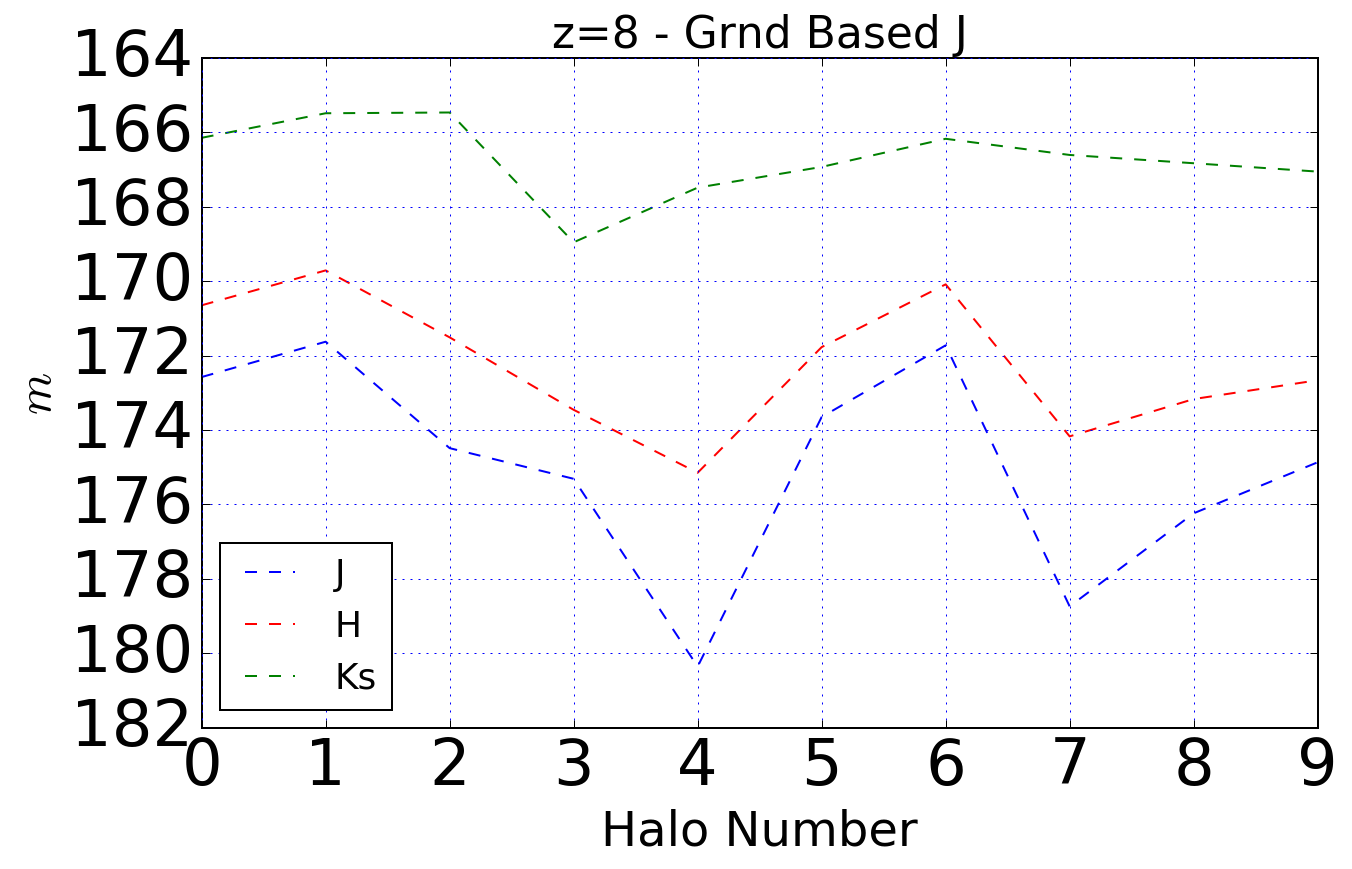

In [129]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['J'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"b--")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['H'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"r--")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['Ks'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"g--")
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'Halo Number', size=labelsize)
ax.set_ylabel(r'$m$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle=':')
ax.set_title(r'z=8 - Grnd Based J',size=labelsize-2)
#ax.xaxis.set_major_formatter(logfmt)
# ax.yaxis.set_major_formatter(logfmt)
ax.invert_yaxis()
# ax.set_ylim([66,56])
ax.legend(['J','H','Ks'], 
          loc='lower left', fontsize=18 )
gc.collect()


NameError: name 'labelsize' is not defined

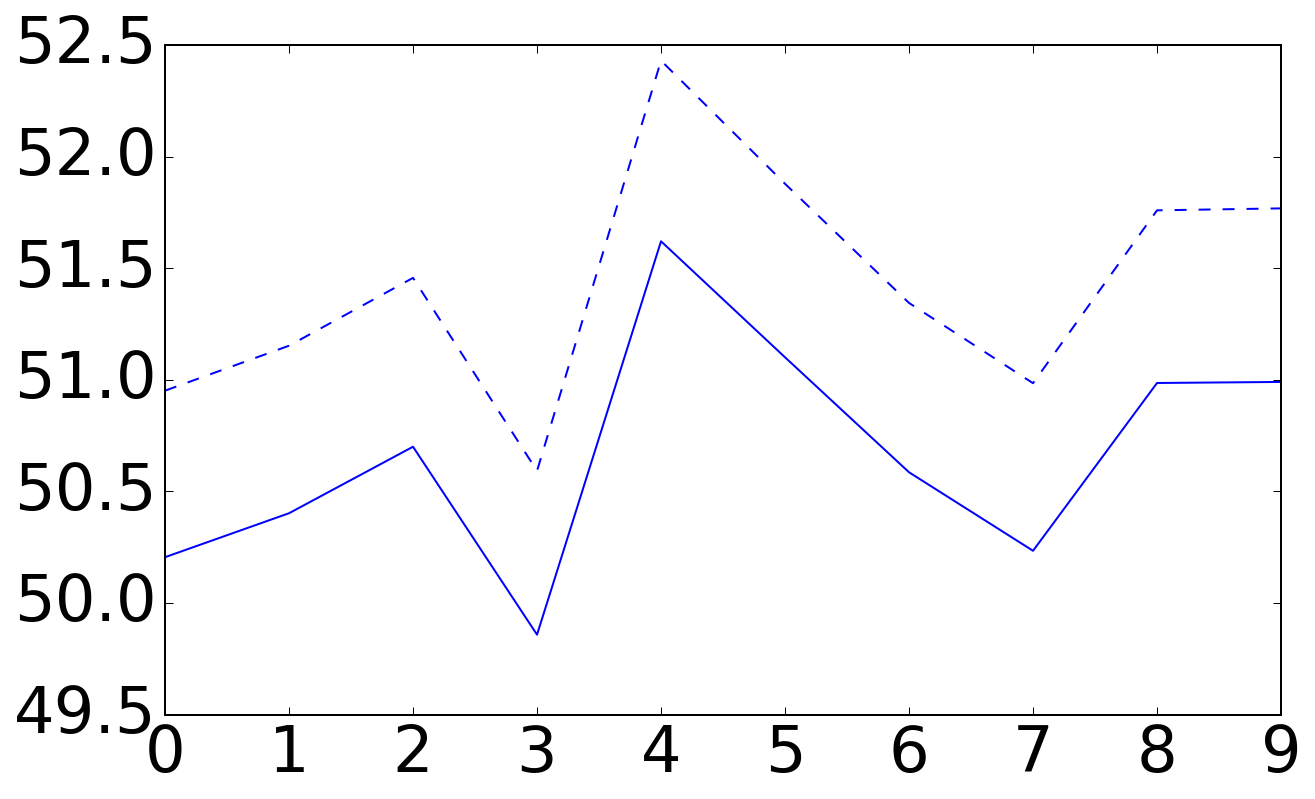

In [26]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['f115w'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"b-")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['F105W_WFC3'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"b--")
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'Halo Number', size=labelsize)
ax.set_ylabel(r'$m$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle=':')
ax.set_title(r'z=8 - Compare similar filters',size=labelsize-2)
#ax.xaxis.set_major_formatter(logfmt)
# ax.yaxis.set_major_formatter(logfmt)
ax.invert_yaxis()
# ax.set_ylim([66,56])
ax.legend(['JWST F115W', 'Hubble F105W'], 
          loc='lower left', fontsize=18 )
gc.collect()


6549

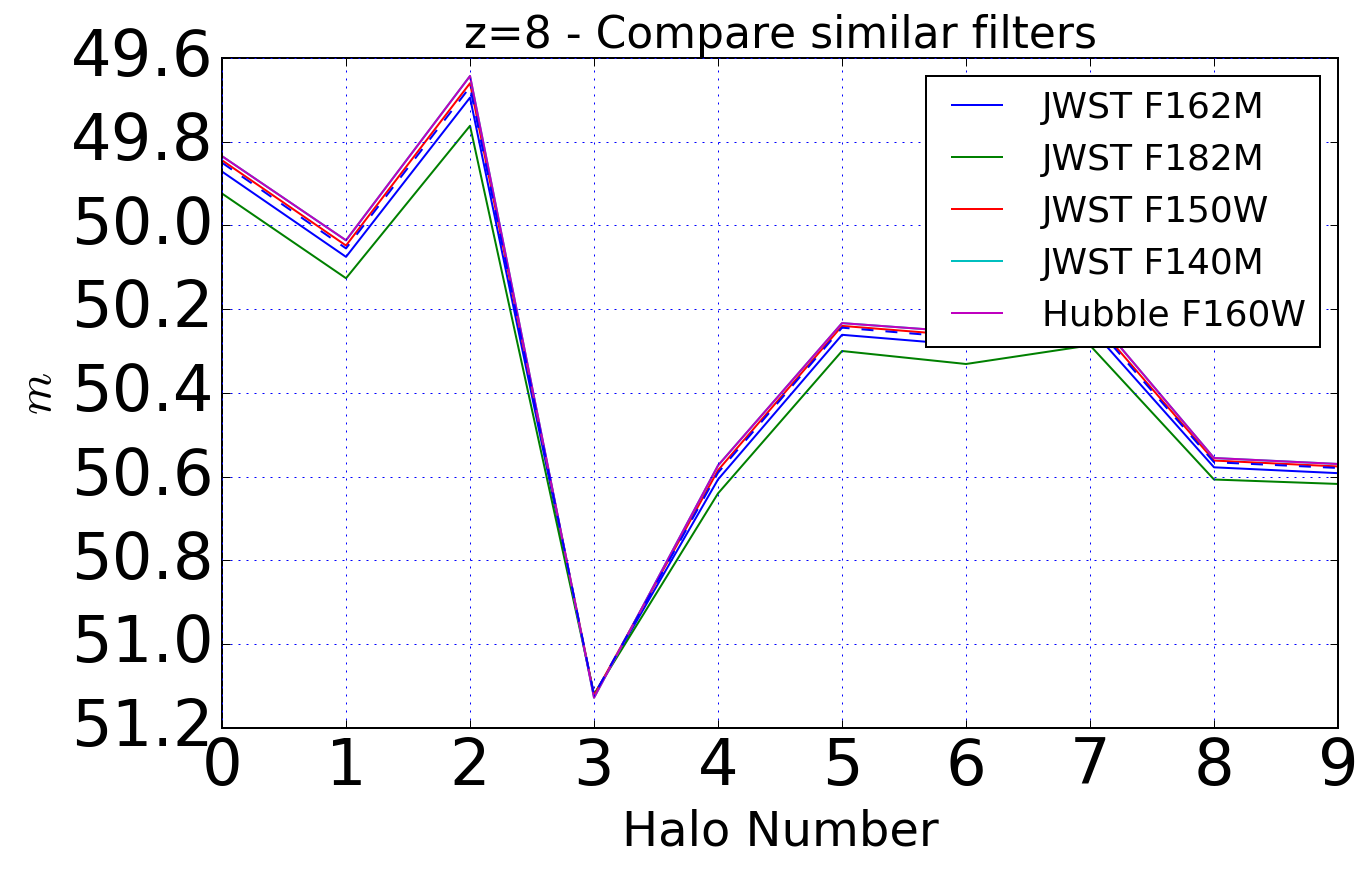

In [137]:
fig = plt.figure(figsize=(10,6))
ax = plt.axes()
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['f162m'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"b-")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['f182m'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"g-")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['f150w'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"r-")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['f140m'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"c-")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['f140m'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"m-")
ax.plot(np.arange(0,10),-2.5*np.log10(myHaloFluxesz8['F160W_WFC3'][0:10]/myHaloFluxesz8['MM_sun'][0:10])-48.6,"b--")
ax.set_xscale('linear')
ax.set_yscale('linear')
ax.set_xlabel(r'Halo Number', size=labelsize)
ax.set_ylabel(r'$m$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle=':')
ax.set_title(r'z=8 - Compare similar filters',size=labelsize-2)
#ax.xaxis.set_major_formatter(logfmt)
# ax.yaxis.set_major_formatter(logfmt)
ax.invert_yaxis()
# ax.set_ylim([66,56])
ax.legend(['JWST F162M', 'JWST F182M', 'JWST F150W', 'JWST F140M', 'Hubble F160W'], 
          loc='upper right', fontsize=18 )
gc.collect()
